## Sampling methods

### Generate random number from different distributions

In [3]:
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# generating uniform random variables
unif_list = stats.uniform.rvs(size = 1000)
print(type(unif_list))

<class 'numpy.ndarray'>


In [5]:
norm = stats.norm
norm.pdf(0)

0.3989422804014327

### Inverse Transform sampling
Example: sampling from an exponential distribution.
For $X \sim exp(\lambda)$, the CDF is F(x) = $1-e^{-\lambda x}$. The technique is to to sampling values of $ u = F(x) $ from a uniform distribution, and then work backward to derive value of x for such u. So $x = F^{-1}(u) = - \frac{1}{\lambda} \ln(1-u) $

In [6]:
def inverse_exp_cdf(u, lambda_val = 1):
    return -1/lambda_val * np.log(1-u)

unif_samples = stats.uniform.rvs(size = 1000)
exp_samples = inverse_exp_cdf(unif_samples)

In [7]:
### let's look at the bar chart of the samples
### divide the values into bins using numpy histogram
def plot_samples(samples, dist, bins=100):
#     rang = samples.max() - samples.min()
#     width = rang / bins
#     hist, bin_edges = np.histogram(samples, bins=bins)
#     if bins <= 100:
#         print(hist)
#         print(bin_edges)
    ### actually draw the plot using pyplot bar chart
    fib, ax = plt.subplots()
#     ax.bar(bin_edges[:-1], hist, width=width) # excluding the last element to equate the number of bins
#     plt.xlim(min(bin_edges), max(bin_edges))
    ax.hist(samples, bins=bins, density=True)
    # compare with the plot of the actual distribution itself
    x = np.linspace(samples.min(), samples.max())
    ax.plot(x, dist.pdf(x), color='red')
    plt.show()

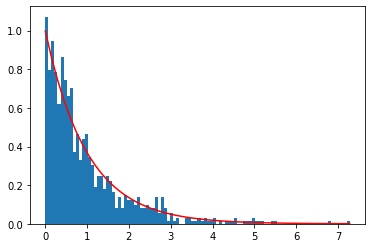

In [8]:
### try ploting with 100 bins
plot_samples(exp_samples, stats.expon)

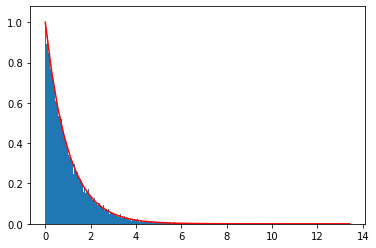

In [9]:
### try ploting with more refined bins => increase samples size too
plot_samples(inverse_exp_cdf(stats.uniform.rvs(size=100000)), stats.expon, bins=1000)

### Rejection sampling
Suppose we want to sample $X$ from the target distribution $\pi(X)$ with PDF $f(x)$
1. Draw $x_{i}$ from the instrumental distribution with PDF $g(x)$
2. Draw $u_{i}$ from $U \sim Unif(0,1)$
3. Consider the ratio $\frac{f(x_{i})}{cg(x_{i})}$:
    - accept $x_{i}$ if $u_{i} \leq \frac{f(x_{i})}{cg(x_{i})}$, in which $c$ is a constant such that $\frac{f(x_{i})}{cg(x_{i})} \in [0, 1]$ over the support of $g$
    - reject otherwise

We see that $u_{i}$ is the chance that $x_{i}$ falls under the curve of $f(x)$, bounded by the curve of $g(x)$

We'll try to sample from a standard normal distribution, using exponential distribution in the first examples and uniform distribution in the second. Each instrumental distribution comes with a different value of c such that c is the minimum value for $cg$ bounds $f$ over the support.
To find c, we solve the equation for the intersection between the PDF curves.

#1: exponential distribution $f(x) = e^{-\lambda x}$. By looking at the graph, we estimate that the value c for this case is approximately 0.705.

#2: uniform distribution. It's easy in this case to solve for c. As we know the peak of normal pdf is at $x=0$, substitute that in the normal pdf we get $f(0) = 0.399$. So $c = 0.399$. Here's the catch, we need to times this by 12 since the support we chose is $[-6, 6]$ while the support of standard uniform distribution is only $[0,1]$

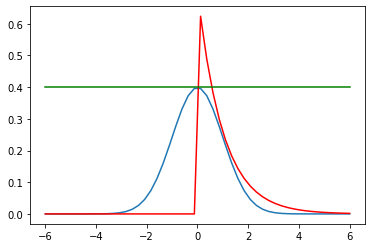

In [144]:
x = np.linspace(-6, 6) # so we pick the support of [-6, 6]
plt.plot(x, stats.norm.pdf(x))
plt.plot(x, 0.705*stats.expon.pdf(x), color='red')
plt.plot(x, 0.399*12*stats.uniform.pdf(x, loc=-6, scale=12), color='green')

In [189]:
def rejection_sampling(target_dist, size, instrumental_dist, c, support=[0,1], instrumental_samples=None, mirror=1):
    '''
        instrumental_samples, if any, must be a generator
    '''
    target_samples = np.array([])
    loc = support[0]
    scale = support[1] - loc
    instrumental_gen = lambda: next(instrumental_samples) if instrumental_samples \
                        else instrumental_dist.rvs(size = 1, loc=loc, scale=scale)[0]
    while len(target_samples) < size:
        x = instrumental_gen()
        u = stats.uniform.rvs(size = 1)
        if u <= target_dist.pdf(x)/(c*instrumental_dist.pdf(x, loc=loc, scale=scale)):
            reflect = stats.uniform.rvs(size = 1)
            if reflect < 0.5:
                x = x*mirror
            target_samples = np.append(target_samples, x)
    return target_samples

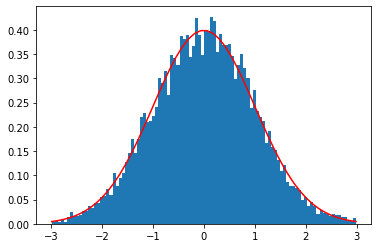

In [190]:
# examples 1: using uniform distribution as the instrumental distribution
norm_samples = rejection_sampling(stats.norm, 10000, stats.uniform, 0.399*6, support=[-3, 3])
plot_samples(norm_samples, stats.norm, bins = 100)

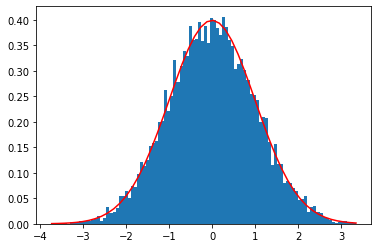

In [197]:
# examples 1: using exponential distribution as the instrumental distribution
c = math.sqrt(math.e/(2*math.pi))
norm_samples = rejection_sampling(stats.norm, 10000, stats.expon, c, mirror=-1)
plot_samples(norm_samples, stats.norm, bins = 100)

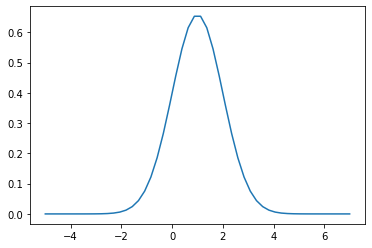

In [181]:
f = lambda x: np.exp(-x**2/2)/(np.sqrt(2*np.pi)*np.exp(-x))
x = np.linspace(-5, 7)
plt.plot(x, f(x))

In [195]:
print(math.sqrt(math.e/(2*math.pi)))
print(math.sqrt(2*math.e/(math.pi)))

0.657744623479457
1.315489246958914
